# DNN

## Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,4)

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error
from plotly.offline import init_notebook_mode, iplot

## Reading data

In [2]:
X_train = pd.read_csv('X_train_complete.csv', index_col=['date'])
y_train = pd.read_csv('y_train_complete.csv', index_col=['date'])

X_test = pd.read_csv('X_test.csv', index_col=['date'])
y_test = pd.read_csv('y_test.csv', index_col=['date'])

In [3]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [4]:
full_data = pd.concat([train_data, test_data], axis=0)

In [5]:
full_data

,maximum_atmospheric_pressure,minimum_atmospheric_pressure,precipitation,maximum_air_temperature,minimum_air_temperature,maximum_relative_humidity,minimum_relative_humidity,total_solar_radiation,maximum_temperature,minimum_temperature,average_air_temperature,average_relative_humidity,wind_speed,total_solar_radiation.1,reference_evapotranspiration
date,,,,,,,,,,,,,,,
2017-01-01,617.799658,599.803362,0.000000,30.318042,28.722792,66.477167,60.174625,2145.823333,21.408342,20.312011,29.543242,63.174958,1.132543,5.960620,0.058537
2017-01-02,620.147296,599.795100,0.000000,29.630875,28.269417,67.488500,61.223083,1951.849667,21.264383,20.061859,28.910676,64.436735,1.087624,5.421805,0.048532
2017-01-03,620.212662,599.817608,0.000000,29.409917,28.005583,70.001792,64.124500,2104.909208,21.635286,20.695279,28.650169,67.002696,1.630787,5.846970,0.064639
2017-01-04,616.165437,599.787975,0.105833,29.755875,28.265958,69.879833,63.227792,1963.737875,21.848865,20.813229,28.881102,66.914866,1.921033,5.454827,0.072362
2017-01-05,619.378317,599.802992,0.000000,28.977792,27.437292,70.608750,64.299542,2001.953125,21.344600,20.438310,28.167198,67.434008,1.197141,5.560981,0.048342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-25,617.598033,599.774778,0.000000,26.162222,25.260667,77.043111,72.860000,2500.997667,21.037083,20.542369,25.666700,75.260879,1.739529,6.947216,0.035565
2017-11-26,618.306160,599.760990,0.000000,25.160600,24.471200,80.193500,75.632100,2459.780530,20.800224,20.227300,24.812676,77.932516,1.118328,7.850408,0.025799
2017-11-27,618.387980,599.769210,0.000000,26.168600,25.124500,79.476900,73.358900,2507.158000,21.240160,20.642043,25.678424,76.354913,1.606195,7.510718,0.034958


In [6]:
BATCH_SIZE = 32
N_INPUT = len(X_train)
N_FEATURES = len(X_train.columns)

In [7]:
trace0 = go.Scatter(
    x = train_data.index,
    y = train_data['reference_evapotranspiration'],
    name = 'Train'
)

trace1 = go.Scatter(
    x = test_data.index,
    y = test_data['reference_evapotranspiration'],
    name = 'Validation'
)

data = [trace0, trace1]

iplot(data)

In [8]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [9]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [10]:
HORIZON = 1
WINDOW_SIZE = 7

In [11]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [12]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [13]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [14]:
timesteps = full_data.index.to_numpy()
re = full_data["reference_evapotranspiration"].to_numpy()

In [15]:
full_windows, full_labels = make_windows(re, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(327, 327)

In [16]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.05853737 0.04853203 0.06463882 0.0723622  0.04834153 0.0520071
 0.04217207] -> Label: [0.05636294]
Window: [0.04853203 0.06463882 0.0723622  0.04834153 0.0520071  0.04217207
 0.05636294] -> Label: [0.04979837]
Window: [0.06463882 0.0723622  0.04834153 0.0520071  0.04217207 0.05636294
 0.04979837] -> Label: [0.04917493]


In [17]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [18]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(261, 66, 261, 66)

In [19]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [20]:
train_windows.shape, train_labels.shape

((261, 7), (261, 1))

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',
                                                  verbose = 1, patience = 20)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=5, min_lr=0.00001)

In [29]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
%%time

tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

rmse = tf.keras.metrics.RootMeanSquaredError()

# Compile model
model_lstm.compile(loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[rmse,'mae'])

history_1 = model_lstm.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_lstm.name)])

INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


CPU times: user 1min 16s, sys: 1.57 s, total: 1min 18s
Wall time: 1min 24s


In [31]:
model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               69632     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


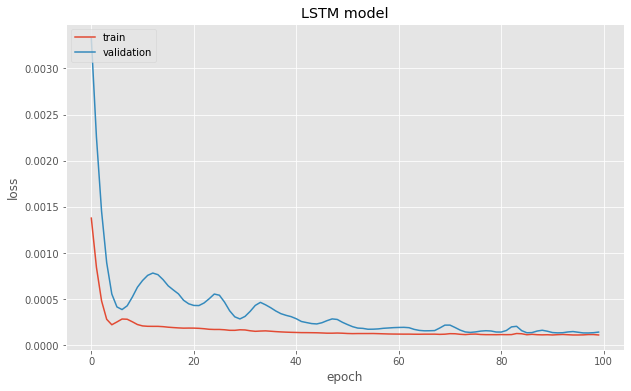

In [32]:
plt.figure(figsize=(10,6))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('LSTM model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

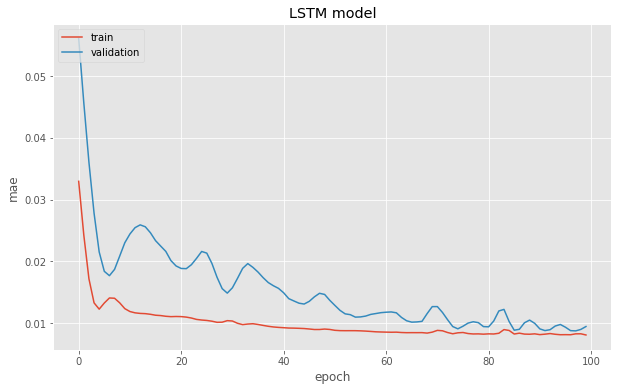

In [33]:
plt.figure(figsize=(10,6))
plt.plot(history_1.history['mae'])
plt.plot(history_1.history['val_mae'])
plt.title('LSTM model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

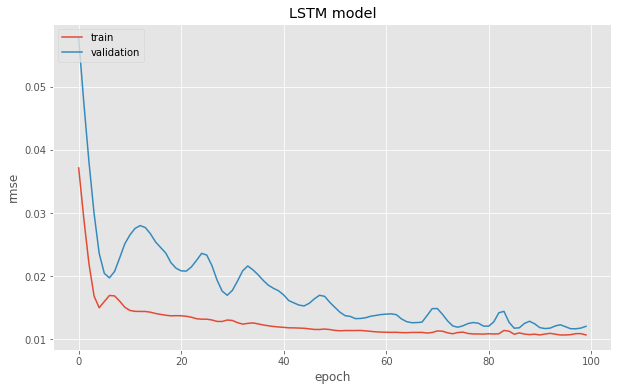

In [34]:
plt.figure(figsize=(10,6))
plt.plot(history_1.history['root_mean_squared_error'])
plt.plot(history_1.history['val_root_mean_squared_error'])
plt.title('LSTM model')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [35]:
model_lstm.evaluate(test_windows, test_labels)


3/3 [==============================] - 0s 4ms/step - loss: 1.4485e-04 - root_mean_squared_error: 0.0120 - mae: 0.0094


[0.00014484698476735502, 0.012035239487886429, 0.009449545294046402]

In [36]:
model_lstm = tf.keras.models.load_model("model_experiments/model_lstm")
model_lstm.evaluate(test_windows, test_labels)

3/3 [==============================] - 0s 5ms/step - loss: 1.3553e-04 - root_mean_squared_error: 0.0116 - mae: 0.0087


[0.00013553074677474797, 0.011641766875982285, 0.008743948303163052]

In [37]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [38]:
# Make predictions using model_dnn on the test dataset and view the results
model_lstm_preds = make_preds(model_lstm, test_windows)
len(model_lstm_preds), model_lstm_preds[:10]

(66, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.0505733 , 0.05229692, 0.05708664, 0.05806523, 0.05984761,
        0.06372562, 0.0634742 , 0.06490812, 0.06889907, 0.06579031],
       dtype=float32)>)

In [40]:
# Evaluate preds
model_lstm_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_lstm_preds)
model_lstm_results

{'mae': 0.008743947,
 'mape': 15.264734,
 'mase': 0.9642172,
 'mse': 0.00013553076,
 'rmse': 0.011641768}

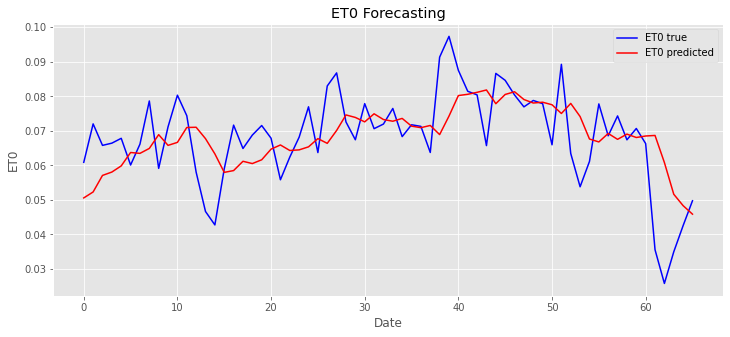

In [41]:
plt.figure(figsize=(12,5))  
plt.plot(tf.squeeze(test_labels), color='blue', label='ET0 true')  
plt.plot(model_lstm_preds, color='red', label='ET0 predicted')  
plt.title('ET0 Forecasting')  
plt.xlabel('Date')  
plt.ylabel('ET0')  
plt.legend()
#plt.savefig("eto.png")
plt.show()

# Saving dnn model and applying transfer learning

In [42]:
model_lstm.save('lstm_model.h5')

In [49]:
loaded_model=tf.keras.models.load_model('lstm_model.h5')

In [50]:
loaded_model.layers

In [51]:
model1=Sequential()
for layer in loaded_model.layers[:-1]:
 model1.add(layer)
 
# Freeze all the layers of base model
for layer in loaded_model.layers:
 layer.trainable=False
 
# adding new layers

model1.add(Dense(32))
#model1.add(Dropout(0.2))
model1.add(Dense(1))

In [52]:
model1.build(input_shape=(WINDOW_SIZE))

In [53]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               69632     
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 73,793
Trainable params: 4,161
Non-trainable params: 69,632
_________________________________________________________________


In [54]:
rmse = tf.keras.metrics.RootMeanSquaredError()

# Compile model
model1.compile(loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[rmse,'mae'])

In [55]:
%%time
history_2 = model1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
              y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
              epochs=100,
              verbose=1,
              batch_size=128,
              validation_data=(test_windows, test_labels),
              callbacks=[create_model_checkpoint(model_name='loaded_model')])

Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 0.0022 - root_mean_squared_error: 0.0470 - mae: 0.0424INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 3s 1s/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - mae: 0.0372 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512 - val_mae: 0.0493
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 5.6062e-04 - root_mean_squared_error: 0.0237 - mae: 0.0183INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 4.4861e-04 - root_mean_squared_error: 0.0212 - mae: 0.0168 - val_loss: 7.5810e-04 - val_root_mean_squared_error: 0.0275 - val_mae: 0.0253
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 3.2838e-04 - root_mean_squared_error: 0.0181 - mae: 0.0152INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 3.8149e-04 - root_mean_squared_error: 0.0195 - mae: 0.0164 - val_loss: 3.6611e-04 - val_root_mean_squared_error: 0.0191 - val_mae: 0.0169
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 4.9378e-04 - root_mean_squared_error: 0.0222 - mae: 0.0189 - val_loss: 4.3579e-04 - val_root_mean_squared_error: 0.0209 - val_mae: 0.0188
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 3.9063e-04 - root_mean_squared_error: 0.0198 - mae: 0.0167 - val_loss: 7.1425e-04 - val_root_mean_squared_error: 0.0267 - val_mae: 0.0245
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 2.7234e-04 - root_mean_squared_error: 0.0165 - mae: 0.0137 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337 - val_mae: 0.0316
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 2.6450e-04 - root_mean_squared_error: 0.0163 - mae: 0.0131 - val_loss: 0.0014 - val_root_mean_squared_erro

INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.5028e-04 - root_mean_squared_error: 0.0123 - mae: 0.0097 - val_loss: 3.2286e-04 - val_root_mean_squared_error: 0.0180 - val_mae: 0.0160
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 1.5559e-04 - root_mean_squared_error: 0.0125 - mae: 0.0100INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.4769e-04 - root_mean_squared_error: 0.0122 - mae: 0.0096 - val_loss: 2.2966e-04 - val_root_mean_squared_error: 0.0152 - val_mae: 0.0130
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 1.5734e-04 - root_mean_squared_error: 0.0125 - mae: 0.0102INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.5692e-04 - root_mean_squared_error: 0.0125 - mae: 0.0099 - val_loss: 2.1681e-04 - val_root_mean_squared_error: 0.0147 - val_mae: 0.0126
Epoch 21/100
3/3 [==============================] - 0s 19ms/step - loss: 1.4932e-04 - root_mean_squared_error: 0.0122 - mae: 0.0096 - val_loss: 2.4107e-04 - val_root_mean_squared_error: 0.0155 - val_mae: 0.0134
Epoch 22/100
3/3 [==============================] - 0s 18ms/step - loss: 1.3731e-04 - root_mean_squared_error: 0.0117 - mae: 0.0092 - val_loss: 2.7695e-04 - val_root_mean_squared_error: 0.0166 - val_mae: 0.0145
Epoch 23/100
3/3 [==============================] - 0s 16ms/step - loss: 1.3241e-04 - root_mean_squared_error: 0.0115 - mae: 0.0090 - val_loss: 3.1006e-04 - val_root_mean_squared_error: 0.0176 - val_mae: 0.0155
Epoch 24/100
3/3 [==============================] - 0s 15ms/step - loss: 1.3248e-04 - root_mean_squared_error: 0.0115 - mae: 0.0090 - val_loss: 3.1136e-04 - val_root_mean_

INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.2847e-04 - root_mean_squared_error: 0.0113 - mae: 0.0088 - val_loss: 2.1158e-04 - val_root_mean_squared_error: 0.0145 - val_mae: 0.0124
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 1.4509e-04 - root_mean_squared_error: 0.0120 - mae: 0.0091INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.2281e-04 - root_mean_squared_error: 0.0111 - mae: 0.0085 - val_loss: 1.5155e-04 - val_root_mean_squared_error: 0.0123 - val_mae: 0.0099
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 1.0661e-04 - root_mean_squared_error: 0.0103 - mae: 0.0080INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 3s 1s/step - loss: 1.3697e-04 - root_mean_squared_error: 0.0117 - mae: 0.0090 - val_loss: 1.3690e-04 - val_root_mean_squared_error: 0.0117 - val_mae: 0.0089
Epoch 29/100
3/3 [==============================] - 0s 18ms/step - loss: 1.4551e-04 - root_mean_squared_error: 0.0121 - mae: 0.0094 - val_loss: 1.3970e-04 - val_root_mean_squared_error: 0.0118 - val_mae: 0.0092
Epoch 30/100
3/3 [==============================] - 0s 18ms/step - loss: 1.3239e-04 - root_mean_squared_error: 0.0115 - mae: 0.0088 - val_loss: 1.6104e-04 - val_root_mean_squared_error: 0.0127 - val_mae: 0.0104
Epoch 31/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1878e-04 - root_mean_squared_error: 0.0109 - mae: 0.0084 - val_loss: 2.1418e-04 - val_root_mean_squared_error: 0.0146 - val_mae: 0.0125
Epoch 32/100
3/3 [==============================] - 0s 17ms/step - loss: 1.2466e-04 - root_mean_squared_error: 0.0112 - mae: 0.0087 - val_loss: 2.2790e-04 - val_root_mean_

INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.1454e-04 - root_mean_squared_error: 0.0107 - mae: 0.0082 - val_loss: 1.3678e-04 - val_root_mean_squared_error: 0.0117 - val_mae: 0.0089
Epoch 56/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1762e-04 - root_mean_squared_error: 0.0108 - mae: 0.0083 - val_loss: 1.3687e-04 - val_root_mean_squared_error: 0.0117 - val_mae: 0.0090
Epoch 57/100
3/3 [==============================] - 0s 18ms/step - loss: 1.1699e-04 - root_mean_squared_error: 0.0108 - mae: 0.0082 - val_loss: 1.3992e-04 - val_root_mean_squared_error: 0.0118 - val_mae: 0.0092
Epoch 58/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1462e-04 - root_mean_squared_error: 0.0107 - mae: 0.0081 - val_loss: 1.4690e-04 - val_root_mean_squared_error: 0.0121 - val_mae: 0.0096
Epoch 59/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1297e-04 - root_mean_squared_error: 0.0106 - mae: 0.0081 - val_loss: 1.4636e-04 - val_root_mean_

INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.1259e-04 - root_mean_squared_error: 0.0106 - mae: 0.0080 - val_loss: 1.3585e-04 - val_root_mean_squared_error: 0.0117 - val_mae: 0.0089
Epoch 75/100
3/3 [==============================] - 0s 20ms/step - loss: 1.1356e-04 - root_mean_squared_error: 0.0107 - mae: 0.0081 - val_loss: 1.3710e-04 - val_root_mean_squared_error: 0.0117 - val_mae: 0.0090
Epoch 76/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1191e-04 - root_mean_squared_error: 0.0106 - mae: 0.0080 - val_loss: 1.4474e-04 - val_root_mean_squared_error: 0.0120 - val_mae: 0.0095
Epoch 77/100
3/3 [==============================] - 0s 19ms/step - loss: 1.1160e-04 - root_mean_squared_error: 0.0106 - mae: 0.0080 - val_loss: 1.4012e-04 - val_root_mean_squared_error: 0.0118 - val_mae: 0.0092
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 1.3107e-04 - root_mean_squared_error: 0.0114 - mae: 0.0086INFO:tensorflow:Assets written to: model_expe

INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.1190e-04 - root_mean_squared_error: 0.0106 - mae: 0.0080 - val_loss: 1.3541e-04 - val_root_mean_squared_error: 0.0116 - val_mae: 0.0089
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 1.1437e-04 - root_mean_squared_error: 0.0107 - mae: 0.0084INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 3s 1s/step - loss: 1.1260e-04 - root_mean_squared_error: 0.0106 - mae: 0.0081 - val_loss: 1.3528e-04 - val_root_mean_squared_error: 0.0116 - val_mae: 0.0089
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 1.0543e-04 - root_mean_squared_error: 0.0103 - mae: 0.0080INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.1342e-04 - root_mean_squared_error: 0.0106 - mae: 0.0081 - val_loss: 1.3373e-04 - val_root_mean_squared_error: 0.0116 - val_mae: 0.0087
Epoch 81/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1347e-04 - root_mean_squared_error: 0.0107 - mae: 0.0081 - val_loss: 1.4250e-04 - val_root_mean_squared_error: 0.0119 - val_mae: 0.0094
Epoch 82/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1314e-04 - root_mean_squared_error: 0.0106 - mae: 0.0081 - val_loss: 1.7876e-04 - val_root_mean_squared_error: 0.0134 - val_mae: 0.0111
Epoch 83/100
3/3 [==============================] - 0s 18ms/step - loss: 1.2794e-04 - root_mean_squared_error: 0.0113 - mae: 0.0089 - val_loss: 1.9824e-04 - val_root_mean_squared_error: 0.0141 - val_mae: 0.0119
Epoch 84/100
3/3 [==============================] - 0s 19ms/step - loss: 1.3102e-04 - root_mean_squared_error: 0.0114 - mae: 0.0090 - val_loss: 1.4842e-04 - val_root_mean_

INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.4539e-04 - root_mean_squared_error: 0.0121 - mae: 0.0094 - val_loss: 1.3336e-04 - val_root_mean_squared_error: 0.0115 - val_mae: 0.0086
Epoch 92/100
3/3 [==============================] - 0s 18ms/step - loss: 1.1884e-04 - root_mean_squared_error: 0.0109 - mae: 0.0083 - val_loss: 1.6029e-04 - val_root_mean_squared_error: 0.0127 - val_mae: 0.0103
Epoch 93/100
3/3 [==============================] - 0s 19ms/step - loss: 1.1598e-04 - root_mean_squared_error: 0.0108 - mae: 0.0083 - val_loss: 1.8297e-04 - val_root_mean_squared_error: 0.0135 - val_mae: 0.0113
Epoch 94/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1970e-04 - root_mean_squared_error: 0.0109 - mae: 0.0085 - val_loss: 1.4509e-04 - val_root_mean_squared_error: 0.0120 - val_mae: 0.0095
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 1.0129e-04 - root_mean_squared_error: 0.0101 - mae: 0.0077INFO:tensorflow:Assets written to: model_expe

INFO:tensorflow:Assets written to: model_experiments/loaded_model/assets


3/3 [==============================] - 2s 1s/step - loss: 1.1107e-04 - root_mean_squared_error: 0.0105 - mae: 0.0080 - val_loss: 1.3263e-04 - val_root_mean_squared_error: 0.0115 - val_mae: 0.0086
Epoch 96/100
3/3 [==============================] - 0s 18ms/step - loss: 1.2421e-04 - root_mean_squared_error: 0.0111 - mae: 0.0085 - val_loss: 1.3392e-04 - val_root_mean_squared_error: 0.0116 - val_mae: 0.0086
Epoch 97/100
3/3 [==============================] - 0s 15ms/step - loss: 1.2371e-04 - root_mean_squared_error: 0.0111 - mae: 0.0085 - val_loss: 1.3298e-04 - val_root_mean_squared_error: 0.0115 - val_mae: 0.0087
Epoch 98/100
3/3 [==============================] - 0s 16ms/step - loss: 1.1192e-04 - root_mean_squared_error: 0.0106 - mae: 0.0080 - val_loss: 1.4998e-04 - val_root_mean_squared_error: 0.0122 - val_mae: 0.0098
Epoch 99/100
3/3 [==============================] - 0s 19ms/step - loss: 1.1422e-04 - root_mean_squared_error: 0.0107 - mae: 0.0082 - val_loss: 1.5268e-04 - val_root_mean_

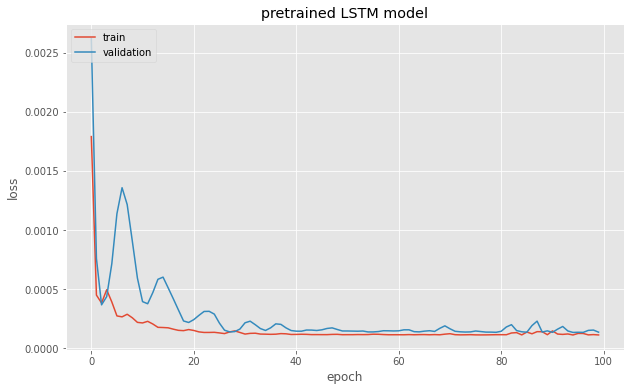

In [56]:
plt.figure(figsize=(10,6))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('pretrained LSTM model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

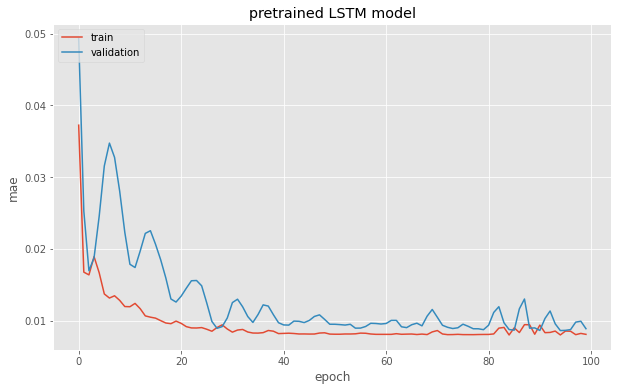

In [57]:
plt.figure(figsize=(10,6))
plt.plot(history_2.history['mae'])
plt.plot(history_2.history['val_mae'])
plt.title('pretrained LSTM model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

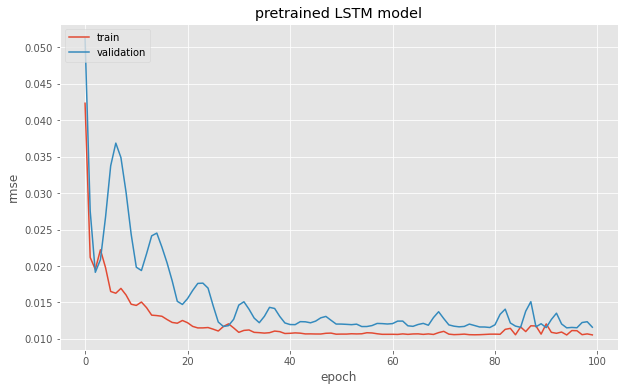

In [58]:
plt.figure(figsize=(10,6))
plt.plot(history_2.history['root_mean_squared_error'])
plt.plot(history_2.history['val_root_mean_squared_error'])
plt.title('pretrained LSTM model')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
model_lstm_transfer = tf.keras.models.load_model("model_experiments/loaded_model")
model_lstm_transfer.evaluate(test_windows, test_labels)

3/3 [==============================] - 0s 5ms/step - loss: 1.3263e-04 - root_mean_squared_error: 0.0115 - mae: 0.0086


[0.00013262937136460096, 0.011516482569277287, 0.008605284616351128]

In [62]:
model_lstm_preds = make_preds(model_lstm_transfer, test_windows)
len(model_lstm_preds), model_lstm_preds[:10]

(66, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.05108123, 0.0532935 , 0.05869132, 0.05938383, 0.06232961,
        0.06559604, 0.06479593, 0.06627332, 0.07027087, 0.06642163],
       dtype=float32)>)

In [64]:
model_lstm_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_lstm_preds)
model_lstm_results

{'mae': 0.008605285,
 'mape': 15.16966,
 'mase': 0.9489265,
 'mse': 0.00013262939,
 'rmse': 0.0115164835}

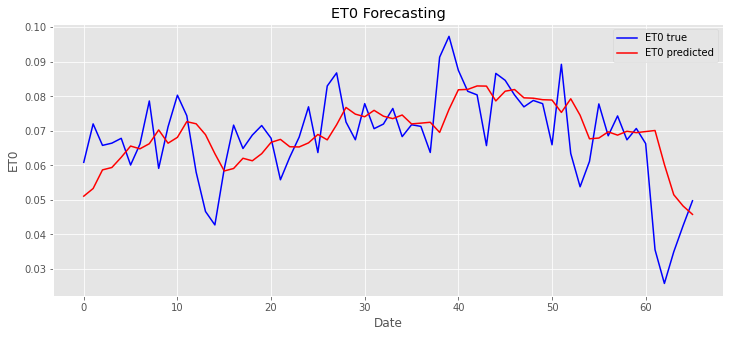

In [65]:
plt.figure(figsize=(12,5))  
plt.plot(tf.squeeze(test_labels), color='blue', label='ET0 true')  
plt.plot(model_lstm_preds, color='red', label='ET0 predicted')  
plt.title('ET0 Forecasting')  
plt.xlabel('Date')  
plt.ylabel('ET0')  
plt.legend()
#plt.savefig("eto.png")
plt.show()

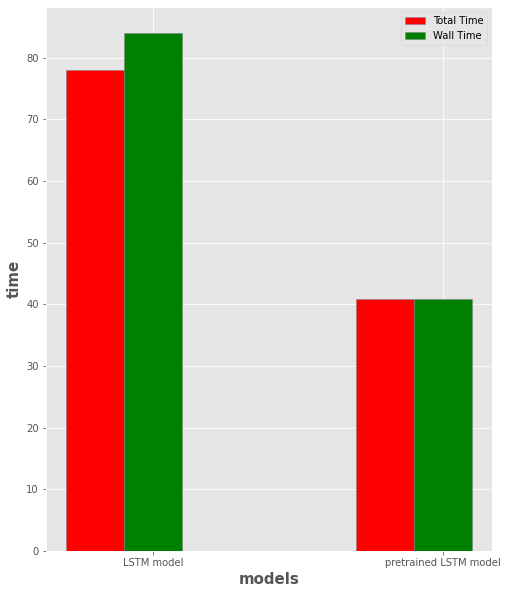

In [67]:
barWidth = 0.20
fig = plt.subplots(figsize =(8, 10))
 
# set height of bar
total_time = [78, 40.9]
wall_time = [84, 40.9]

 
# Set position of bar on X axis
br1 = np.arange(len(total_time))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, total_time, color ='r', width = barWidth,
        edgecolor ='grey', label ='Total Time')
plt.bar(br2, wall_time, color ='g', width = barWidth,
        edgecolor ='grey', label ='Wall Time')
 
# Adding Xticks
plt.xlabel('models', fontweight ='bold', fontsize = 15)
plt.ylabel('time', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(total_time))],
        ['LSTM model', 'pretrained LSTM model'])
 
plt.legend()
plt.show()

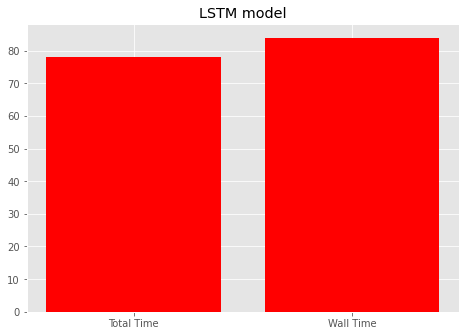

In [68]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Total Time', 'Wall Time']
time = [78,84]
ax.bar(x,time,color='r')
plt.title('LSTM model')
plt.show()

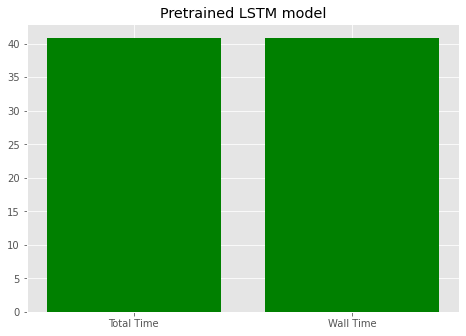

In [69]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Total Time', 'Wall Time']
time = [40.9,40.9]
ax.bar(x,time,color='g')
plt.title('Pretrained LSTM model')
plt.show()